**LABORATORIO 4**

* Dataset:https://drive.google.com/drive/folders/14MZNuZg5xmbKtR3L9Wq_Tdwu9eyNliL6?usp=sharing
* repositorio github:https://github.com/R1mber/sis421/tree/master/Laboratorios
* DenseNet creada 2016 ultima actualizacion 2018

In [1]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
cp -av "/content/drive/MyDrive/ia 2/dataset_flores" "/content/img"

'/content/drive/MyDrive/ia 2/dataset_flores' -> '/content/img/dataset_flores'


In [18]:
#cp -av /content/drive/MyDrive/inteligencia_artificial/ia2/dataset_flores /content/img

In [23]:
path = '/content/img/'
directorios = os.listdir(path)
directorios

['tagetes',
 'Hibisco',
 'FlorRita',
 'claveles',
 'lirio',
 'Girasoles',
 'rosas',
 '.ipynb_checkpoints']

In [24]:
labels_def = {'Hibisco':0, 'Girasoles':1, 'tagetes':2, 'FlorRita':3, 'claveles':4,'lirio':5, 'rosas':6}

In [25]:
def loadImages(path, directorio):
    labels_ = []
    images_ = []
    for d in directorio:
        imagenes = os.listdir(path + d)
        for i in imagenes:
            imgPath2 = path + d + '/' + i
            images_.append(imgPath2)
            labels_.append(labels_def[d])
    return images_, labels_
def getText(label):
    for key in labels_def:
      if labels_def[key] == label:
        return key

In [26]:
imgs , labels = loadImages(path,directorios)

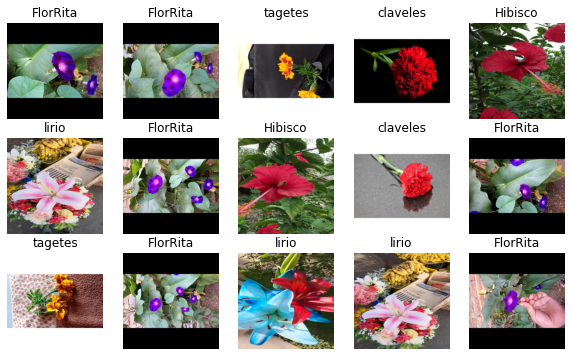

In [27]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getText(labels[ix]))
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.05, stratify=labels)

len(train_imgs), len(test_imgs)

(7382, 389)

In [29]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X #torch.from_numpy(X).float().cuda()
        self.Y = Y #torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        img1 = Image.open(self.X[ix])
        new_img = img1.resize((60,60))
        #normalizamos la imagen 
        npImage = np.array(new_img)
        #return self.X[ix], self.Y[ix]
        #img = self.trans(image=img)["image"]
        return torch.from_numpy(npImage / 255.).float().permute(2,0,1), torch.tensor(self.Y[ix])

In [30]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
len(dataset['train']), len(dataset['test']),

(7382, 389)

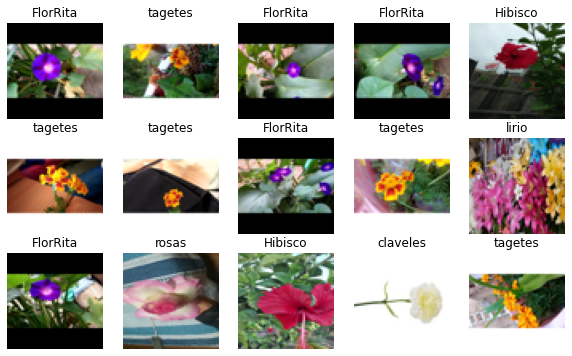

In [31]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))
    #ax.set_title(classes[lab])
plt.show()

In [32]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=65, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=50, shuffle=False)
}

x_train, y_train = next(iter(dataloader['train']))


densenet201

torchvision.models.densenet201(pretrained: bool = False, progress: bool = True, **kwargs: Any) → torchvision.models.densenet.DenseNet

* Densenet-201 model from “Densely Connected Convolutional Networks”. The required minimum input size of the model is 29x29.

    Parameters

    * pretrained (bool) – If True, returns a model pre-trained on ImageNet

    * progress (bool) – If True, displays a progress bar of the download to stderr

    * memory_efficient (bool) – but slower. Default: False. See “paper”

In [33]:
import torchvision

densenet = torchvision.models.densenet201()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [34]:
from torch.nn.modules.activation import ReLU6
from torchvision.ops.misc import ConvNormActivation
def block0(c_in=3, c_out=64, k=7, p=3, s=2, pk=3, ps=2,pp=1):
    return torch.nn.Sequential(
            torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s, bias=False),
            torch.nn.BatchNorm2d(c_out,1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )

def block(c_in, c_out, k=3, p=1, s=1, c2k=3, c2s=1, c2p=1):
    return torch.nn.Sequential(
        torch.nn.BatchNorm2d(c_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(c_in, 128,kernel_size=k, padding=p, stride=s),
        torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(128, c_out, kernel_size=c2k , padding=c2p, stride=c2s),
    )
def denseBlock(c_in, c_out):
    return torch.nn.Sequential(
        block(64,64,k=1,s=1,c2k=3,c2s=1,c2p=1),
        block(64,128,k=1,s=1,c2k=3,c2s=1,c2p=1)
    )

def transition(c_in, c_out, k=1, p=0, s=1, pk=2, ps=2, pp=0):
    return torch.nn.Sequential(
        torch.nn.BatchNorm2d(c_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(c_in,c_out, kernel_size=k, stride=s, bias=False),
        torch.nn.AvgPool2d(kernel_size=pk, stride=ps, padding=pp)
    )

In [35]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=7):
    super().__init__()
    self.conv0 = block0()
    self.dense1 = denseBlock(64,128)
    self.transition1 = transition(128,128, pk=2,ps=2,pp=0)
    #self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*9*9, n_outputs)

  def forward(self, x):
    #print("Dimensiones:")
    #print("Entrada: ", x.shape)
    x = self.conv0(x)
    #print("conv and pooling: ", x.shape)
    x = self.dense1(x)
    #x = self.conv2(x)
    #print("bloque densa1 : ", x.shape)
    x = self.transition1(x)
    #print("transition : ", x.shape)
    x = x.view(x.shape[0], -1)
    #print("pre fc: ", x.shape)
    x = self.fc(x)
    #print("Salida: ", x.shape)
    return x

In [36]:
model = CNN()

output = model(torch.randn(64, 3, 60, 60))

In [37]:
from tqdm import tqdm
import numpy as np
device = "cuda"
def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN()
fit(model, dataloader)

loss 0.44899 acc 0.86593:  18%|█▊        | 21/114 [03:12<14:18,  9.23s/it]